# Классификация дефектов кожи

## Дипломная работа Жеманцевой Татьяны. Skillfactory.

## Задача: создание модели классификации, которая по представленной картинке кожного покрова сможет определить варианты с процентным 
## соотношением похожести данного дефекта на известное заболевание.
 
## Данные взяты с kaggle - закрытое соревнование, данные для которого взяты и отсортированы в ISIC (https://www.isic-archive.com).
## В данной работе выполнена классификация с использованием CNN и предобученой нейросети в Tensorflow - Xception.

In [1]:
#!pip install -q tensorflow==2.3
#!pip install keras_efficientnets
#!pip freeze > requirements.txt

# Импортируем библиотеки 

In [2]:
# Импортируем библиотеки

import pandas as pd # импортируем необходимые библиотеки
import numpy as np
import re
import random
import os
import sys
import PIL
import cv2

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import ExtraTreeRegressor
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 

from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import itertools 

#from catboost import CatBoostRegressor

from tqdm import tqdm
from tqdm.notebook import tqdm

from itertools import combinations
from scipy.stats import ttest_ind


# # keras
import tensorflow as tf
from tensorflow import keras
#import tensorflow.keras.layers as L
#from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#import albumentations
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
#from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
#import tensorflow as tf
import tensorflow.keras 
import tensorflow.keras.models #as M
#import tensorflow.keras.layers as L
#import tensorflow.keras.backend #as K
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay as ExpDecay

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from glob import glob
from glob import iglob
#from keras.applications import InceptionV3
#from keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense ,LeakyReLU,UpSampling2D, GlobalAveragePooling2D,Conv2DTranspose, BatchNormalization,GlobalMaxPool2D, Convolution2D

import nltk
from nltk.corpus import stopwords

# plt
import matplotlib.pyplot as plt
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
#DATA_PATH = "/content/drive/My Drive/cars2/"
#PATH = "/content/"  # рабочая директория

In [3]:
#from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import EfficientNetB4
print(keras.__version__)
print(tf.__version__)

2.4.0
2.4.0


In [4]:
print(tf.__version__)

2.4.0


In [5]:
#from tensorflow.keras.applications import InceptionV3#

In [6]:
#keras.applications.EfficientNetB4()

In [7]:
print('Python       :', sys.version.split('\n')[0])
print('Numpmodel.summary()y        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 21:08:20) 
Numpmodel.summary()y        : 1.19.5
Tensorflow   : 2.4.0


# Задаем константы

In [8]:
train_path = "/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
test_path = "/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration/Skin cancer ISIC The International Skin Imaging Collaboration/Test/"

In [9]:
RANDOM_SEED = 42
IMAGE_SIZE         = (299, 299)
#INPUT_SHAPE        = (224, 224, 3)
IMG_SIZE           = 299 # размер входного изображения для Xception по-умолчанию
IMG_CHANNELS       = 3   # у RGB 3 канала
input_shape        = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
# Keras settings
BATCH_SIZE = 2
VAL_BATCH_SIZE = 2
VAL_SPLIT          = 0.12 # сколько данных выделяем на тест = 15%
EPOCHS = 12
LR = 0.00001

# Предобработка изображений: просмотр, аугментация, создание обучающего и тестового наборов

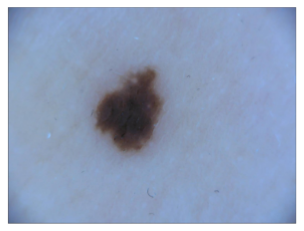

In [11]:
# Посмотрим пример картинки

img = PIL.Image.open(train_path + "nevus/ISIC_0000041.jpg") # load_img(train_path + "nevus/ISIC_0000041.jpg")  "ISIC_0000398.jpg"
plt.imshow(img)
plt.axis("off")
plt.show()


In [12]:
# Преобразуем картинку в массив

x = img_to_array(img)
print(x.shape)

(1129, 1504, 3)


In [13]:
# C помощью glob определяем сколько разных папок-классов с картинками имеется.

className = glob(train_path + '/*' )
numberOfClass = len(className)
print("NumberOfClass: ",numberOfClass)

NumberOfClass:  9


In [14]:
className

['/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis',
 '/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma',
 '/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion',
 '/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis',
 '/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma',
 '/kaggle/input/skin-cancer9-classesisic/

## Аугментация с помощью ImageDataGenerator (выполняется либо этот раздел аугментации, либо следующий )

In [106]:
# Аугментация обучающего датасета
# Официальная документация: https://keras.io/preprocessing/image/

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 60,
    brightness_range = [0.5, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=[0.75,1.25],
    fill_mode='reflect')  #  fill_mode='nearest'

       
test_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataAugmentor(rescale=1. / 255, validation_split=VAL_SPLIT)

In [107]:
# Завернем наши данные в генератор.

train_generator = train_datagen.flow_from_directory(
    train_path,      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation') # set as validation data


Found 1975 images belonging to 9 classes.
Found 264 images belonging to 9 classes.


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


In [108]:
test_val_generator = test_datagen.flow_from_directory(
    directory=test_path,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)


Found 118 images belonging to 9 classes.


In [ ]:
train_generator

## Аугментация с помощью albumentations (выполняется либо этот раздел аугментации, либо предыдущий)

In [15]:
!pip install albumentations

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [16]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-1ppwbzpo
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-1ppwbzpo
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=09206b26a3b893777c367f1cdb8bd7acc39b52a28ecdd14d09396bb06686a6eb
  Stored in directory: /tmp/pip-ephem-wheel-cache-g4_l8e72/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [17]:
#Аугментация данных важна, когда мы работаем с небольшим датасетом. Это как раз наш случай.

import albumentations
import cv2
from ImageDataAugmentor.image_data_augmentor import *
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

In [18]:
# попробовать этот вариант

AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5), #0.5
    albumentations.Rotate(limit=90),
    albumentations.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
    albumentations.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
   # albumentations.HueSaturationValue(p=0.5),
    albumentations.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.00, always_apply=False, p=0.5),
    albumentations.RandomContrast(limit=0.1, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )

      
test_datagen = ImageDataAugmentor(rescale=1./255)

val_datagen = ImageDataAugmentor(rescale=1. / 255, validation_split=VAL_SPLIT)

In [ ]:
# Либо этот вариант. 


AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5), #0.5
    albumentations.Rotate(limit=20, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=IMG_SIZE, width=IMG_SIZE),
        albumentations.CenterCrop(height=IMG_SIZE, width=IMG_SIZE),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
   # albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )

      
test_datagen = ImageDataAugmentor(rescale=1./255)

val_datagen = ImageDataAugmentor(rescale=1. / 255, validation_split=VAL_SPLIT)

In [24]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    train_path,      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data



Found 1975 images belonging to 9 classes.
Found 264 images belonging to 9 classes.


In [25]:
test_val_generator = test_datagen.flow_from_directory(
    directory=test_path,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 118 images belonging to 9 classes.


In [109]:
# Переведем картинки в массивы

train_pairs = [next(train_generator) for i in range(len(train_generator))]
val_pairs = [next(test_generator) for i in range(len(test_generator))]
train_images = np.concatenate([x[0] for x in train_pairs], axis = 0)
train_labels = np.concatenate([x[1] for x in train_pairs], axis = 0)
val_images = np.concatenate([x[0] for x in val_pairs], axis = 0)
val_labels = np.concatenate([x[1] for x in val_pairs], axis = 0)

In [64]:
#val_df=val_labels.flatten() 
tr_df = train_labels.flatten() 

Пример картинок из train_generator


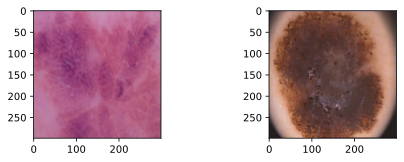

In [28]:
# Прсмотрим несколько картинок после применения аугментации.

from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,2):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
   # plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

In [29]:
imgs, labels = next(train_generator)
print(imgs.shape, labels.shape)

(2, 299, 299, 3) (2, 9)


In [52]:
imgs, labels = next(test_generator)
print(imgs.shape, labels.shape)
print(len(test_generator))

(2, 299, 299, 3) (2, 9)
132


# Посмотрим распределение данных по классам.

In [37]:

def classes_count (path):
    # определяет содержимое папок классов
    
    classes = []
    for filename in iglob(os.path.join(path, "**","*.jpg")):
        classes.append(os.path.split(os.path.split(filename)[0])[-1])
    cnt = Counter(classes)
    return cnt

def percentage_value(pct, allvals):
    # вычисляет процентное значение размера класса
    
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

def plot_dataset_description(path, title):
    # строит круговую диаграмму
    
    classes_cnt = classes_count(path)
    values = list(classes_cnt.values())
    labels = list(classes_cnt.keys())

    plt.figure(figsize=(8,8))
    plt.pie(values, labels=labels, autopct=lambda pct: percentage_value(pct, values), 
            shadow=True, startangle=140)

    plt.title(title + ' размера ' + str(sum(classes_cnt.values())))    
    plt.show()

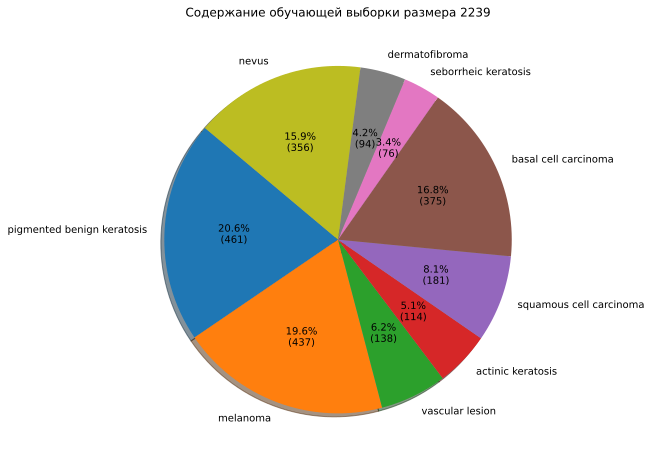

In [38]:
plot_dataset_description(os.path.join(train_path), "Содержание обучающей выборки")

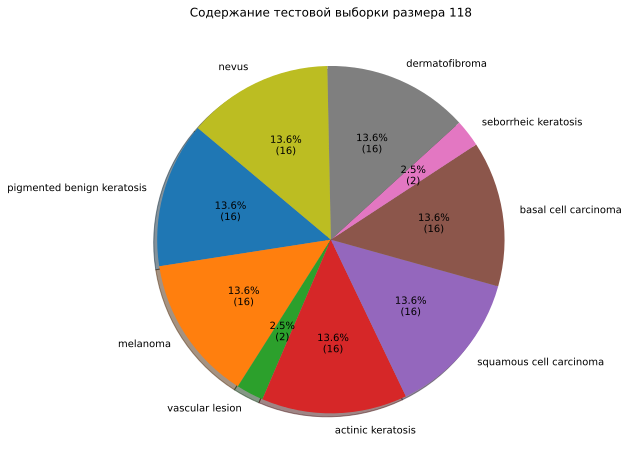

In [39]:
plot_dataset_description(os.path.join(test_path), "Содержание тестовой выборки")

In [57]:
def plot_dataset_description_bar(path, title):
    # строит диаграмму столбиками
 
    classes_val = classes_count(path)
    

    values = list(classes_val.values())
    labels = list(classes_val.keys())
    #print (labels)
    #index = [n for n in range(numberOfClass)]
    plt.figure(figsize=(10, 5))
    #hist, bins = np.histogram(values, bins=9)
    plt.bar(values, (values), width=10)
 #   plt.bar(range(len(values)),[values[k] for k in values], width=20)
    
    #plt.xlabel('Градация болезней', fontsize=10)
    plt.ylabel('Количество картинок', fontsize=10)
    plt.xticks(values, labels, fontsize=8, rotation=90)
    plt.title(title)

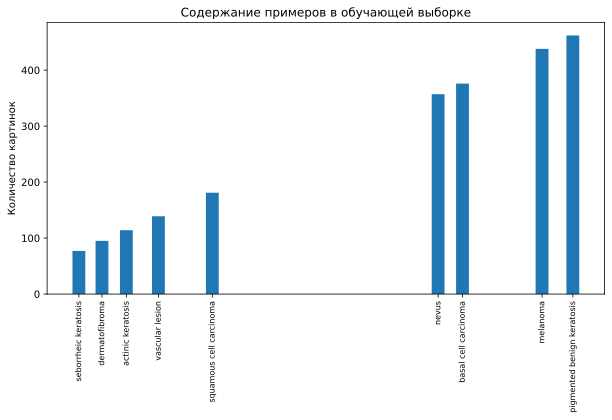

In [58]:
plot_dataset_description_bar(os.path.join(train_path), 'Содержание примеров в обучающей выборке')

In [66]:
plot_dataset_description_bar(os.path.join(test_path), 'Содержание примеров в тестовой выборке')

# Анализ данных показывает, что наша выборка несбалансирована, поскольку самый многочисленный класс в 5 раз превышает самый маленький.
# В этом случае нам подошли бы метрики precision, recall, F1-score, учитывающие веса классов, но они используются только в бинарной классификации. А проблема accuracy в том, что она не учитывает веса классов.
# Поэтому для каждого класса добавлены веса классов в параметр class_weight при обучении,что позволило повысить точность модели.
# В данной задаче, как и большинстве задач, связанных с медициной наиболее критичной является ошибка первого рода.

 
# В задаче для оценки эффективности  модели в процессе обучения я использовала
# 1. accurancy - без использования class_weight максимальный результат достигал порядка 56%
# 2. Для многоклассовой выборки с несбалансированными классами на просторах интернета рекомендуют использовать метрику macro F1. Создала свои функции для подсчета loss и macro F1 - решение давало достаточно низкую степень обучаемости, от идеи отказалась. на 45 эпохе результаты: loss: 1.0659 - f1: 0.2935 - val_loss: 1.8877 - val_f1: 0.1625
# Также попробовала оптимизацию по созданной функции потерь F1_loss - на 40й эпохе результат F1 = 0.23.

# 3. Оптимизировала модель по loss - категориальная кросс энтропия. 

 



# Построение и обучение модели.

In [ ]:
#model = keras.models.load_model('/kaggle/input/inputmod/best_model_step1.hdf5')

## Вынесем функции для раздела построения и обучения модели.

In [67]:
def info_layers():
    # вывод информации по слоям модели в процессе тюнинга
    
    print("Number of layers in the model:", len(model.layers))
    print("Number of trainable_variables layers in the model:", len(model.trainable_variables))
    print("Number of layers in the base model: ", len(base_model.layers))
    print("Number of variables layers in the base model: ", len(base_model.trainable_variables))
    print("Layers in the model:")
    for layer in model.layers:
        print(layer, layer.trainable)

def graph(history):
    # построние графиков изменения метрики и функции потерь в процессе обучения по эпохам
    
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], 'b*-', label="training acc")
    plt.plot(history.history['val_accuracy'], 'r*-', label="validation acc")
    plt.grid()
    plt.title("train_acc vs val_acc")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], 'b*-', label="training loss")
    plt.plot(history.history['val_loss'], 'r*-', label="validation loss")
    plt.grid()
    plt.title("Training and validation loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    
    


In [ ]:
# Создадим собственную метрику f1 и функцию потерь - f1_loss

from keras import backend as K

def f1(y_true, y_pred):
    # метрика macro F1
    
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    # функция потерь
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [68]:
# CallBack для сохранения модели, ее весов и лучшей модели, изменения LR в случае отсутствия прогресса обучения, и остановка обучения

weightpath = "best_model.hdf5"
#checkpoint = ModelCheckpoint(weightpath , monitor = 'val_f1' , mode = 'max', verbose = 1,save_best_only=True)
#checkpoint = ModelCheckpoint(weightpath , monitor = 'val_precision' , mode = 'max', verbose = 1,save_best_only=True) #save_weights_only=True
checkpoint = ModelCheckpoint(weightpath , monitor = 'val_accuracy' , mode = 'max', verbose = 1,save_best_only=True) #save_weights_only=True
reducer = ReduceLROnPlateau(monitor='loss', patience= 3,factor=0.2, min_lr=0.00000001,  verbose = 1, cooldown=2, mode='min',min_delta=0.0000001) #min_delta=0.000000001
early_stop= EarlyStopping(monitor='loss',patience= 10, mode='min')  #min_delta=0.000000001


In [69]:
callbacks_list = [checkpoint, reducer, early_stop] 

In [110]:
# Выведем классы для удобства проставления весов

classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

{0: 'actinic keratosis', 1: 'basal cell carcinoma', 2: 'dermatofibroma', 3: 'melanoma', 4: 'nevus', 5: 'pigmented benign keratosis', 6: 'seborrheic keratosis', 7: 'squamous cell carcinoma', 8: 'vascular lesion'}


In [111]:
# Установим вес "2"и "3" для классов, размер которых в 2-3 раза меньше самых больших классов, сделав эти классы в 2-3 раза важнее

class_weight = {0: 3., 1: 1., 2: 2.4, 3: 1.5, 4: 1., 5: 1., 6: 2.9, 7: 2.2, 8: 2.}

## Шаг1  Сформируем модель

In [ ]:
# В процессе обучения проводились опыты с разными моделями, в качестве base_model необходимо выбрать  Xception, 
# как показавшую лучшие результаты

#base_model2 = EfficientNetB4(weights='imagenet', include_top=False, input_shape=input_shape)

In [70]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

83689472/83683744 [==============================] - 1s 0us/step


In [71]:
# Установим все слои base_model в неактивное состояние

base_model.trainable = False

In [39]:
model=Sequential()
model.add(base_model)

#model.add(GlobalAveragePooling2D(),)
#model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
#model.add(BatchNormalization())
print('ок')
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
#model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
#model.add(L.Dense(512,activation='relu'))
#model.add(L.BatchNormalization())
model.add(Dense(numberOfClass, activation='softmax'))

ок


In [ ]:
# лучшая модель 

model=Sequential()
##model.add(base_model)

##model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
print('ок')
model.add(Flatten())
#model.add(Dense(1024, activation='relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
#model.add(L.Dense(512,activation='relu'))
#model.add(L.BatchNormalization())
model.add(Dense(numberOfClass, activation='softmax'))

In [ ]:
train_generator.samples

In [ ]:
test_generator.samples

In [ ]:
model = Sequential()
model.add(Xception(include_top = False, weights = "imagenet",
                        input_shape=(IMG_SIZE,IMG_SIZE, 3)))
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(numberOfClass, activation = "softmax"))



In [72]:
# CNN модель с добавлением Xception, которая показала наилучший результат 

model = Sequential()
 
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(numberOfClass, activation='softmax'))



In [73]:
# Посмотрим информацию о количестве слоев модели и модели Imagenet

info_layers()

Number of layers in the model: 7
Number of trainable_variables layers in the model: 6
Number of layers in the base model:  132
Number of variables layers in the base model:  0
Layers in the model:
<tensorflow.python.keras.engine.functional.Functional object at 0x7f486b5a7910> False
<tensorflow.python.keras.layers.core.Flatten object at 0x7f486b46fc50> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f486b46f750> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f4821606a90> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f482164cb10> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f48215e8810> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f48215d2e50> True


In [74]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 112

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [75]:
info_layers()

Number of layers in the model: 7
Number of trainable_variables layers in the model: 29
Number of layers in the base model:  132
Number of variables layers in the base model:  23
Layers in the model:
<tensorflow.python.keras.engine.functional.Functional object at 0x7f486b5a7910> True
<tensorflow.python.keras.layers.core.Flatten object at 0x7f486b46fc50> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f486b46f750> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f4821606a90> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f482164cb10> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f48215e8810> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f48215d2e50> True


In [76]:
# Посмотрим структуру модели

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               52429056  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install pydot

In [77]:
# Посмотрим на схему модели.

from keras.utils import plot_model
plot_model(model,show_shapes=True,show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [81]:
# Компилируем модель

#f1_m = 2*((tf.keras.metrics.Precision()*tf.keras.metrics.Recall())/(tf.keras.metrics.Precision()+tf.keras.metrics.Recall()+tf.epsilon()))
LR=0.0009
model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=[tf.keras.metrics.Precision()])
#model.compile(optimizer=optimizers.Adam(LR),loss=f1_loss, metrics=f1)
#model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=f1)

In [82]:
%%time
history = model.fit(
        #train_generator,
        train_images, train_labels,
        steps_per_epoch=len(train_generator), #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 20, #EPOCHS,
        class_weight=class_weight,
        validation_data=test_generator,
        #validation_data= val_images,
        #validation_steps=len(test_generator), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

Epoch 1/20
988/988 [==============================] - 44s 38ms/step - loss: 4.0453 - accuracy: 0.1673 - val_loss: 2.1324 - val_accuracy: 0.1894

Epoch 00001: val_accuracy improved from -inf to 0.18939, saving model to best_model.hdf5
Epoch 2/20
988/988 [==============================] - 37s 37ms/step - loss: 3.1983 - accuracy: 0.1786 - val_loss: 2.1314 - val_accuracy: 0.1932

Epoch 00002: val_accuracy improved from 0.18939 to 0.19318, saving model to best_model.hdf5
Epoch 3/20
988/988 [==============================] - 36s 36ms/step - loss: 3.2164 - accuracy: 0.1807 - val_loss: 2.1073 - val_accuracy: 0.1970

Epoch 00003: val_accuracy improved from 0.19318 to 0.19697, saving model to best_model.hdf5
Epoch 4/20
988/988 [==============================] - 36s 36ms/step - loss: 3.1253 - accuracy: 0.1908 - val_loss: 2.0687 - val_accuracy: 0.1932

Epoch 00004: val_accuracy did not improve from 0.19697
Epoch 5/20
988/988 [==============================] - 36s 36ms/step - loss: 3.1091 - accurac

In [73]:
history.history
#loss: 0.1100 - precision: 0.9824 - val_loss: 4.3982 - val_precision: 0.4840   -- 0.00008
#loss: 1.6093 - precision_1: 0.7621 - val_loss: 1.9980 - val_precision_1: 0.6232  -- LR=0.0007
#loss: 1.8622 - precision_2: 0.6718 - val_loss: 1.7129 - val_precision_2: 0.6943  --0.001
#loss: 1.5776 - precision_2 0.8497 - val_loss: 2.0402 - val_precision_3: 0.5302  --0.00017

{'loss': [3.1349897384643555,
  2.93794322013855,
  2.6647887229919434,
  2.516345262527466,
  2.4048306941986084,
  2.3116796016693115,
  2.279423713684082,
  2.1014835834503174,
  2.0443003177642822,
  2.078808546066284,
  2.085359811782837,
  1.8637501001358032,
  1.7981683015823364,
  1.7565877437591553,
  1.6933705806732178,
  1.553707242012024,
  1.4569379091262817,
  1.3884499073028564,
  1.4864122867584229,
  1.6049448251724243],
 'precision_1': [0.4046242833137512,
  0.47346073389053345,
  0.4932975769042969,
  0.6000000238418579,
  0.5960000157356262,
  0.6041666865348816,
  0.6120944023132324,
  0.6339031457901001,
  0.6621786952018738,
  0.6554726362228394,
  0.6544944047927856,
  0.6896135210990906,
  0.6844978332519531,
  0.7097130417823792,
  0.7156756520271301,
  0.7314172387123108,
  0.7532956600189209,
  0.7679403424263,
  0.7397831678390503,
  0.7489878535270691],
 'val_loss': [2.187997817993164,
  1.9998862743377686,
  1.9232286214828491,
  1.6994922161102295,
  1.7

In [83]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last_v1.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
#model = keras.models.load_model('model_last_111.hdf5')

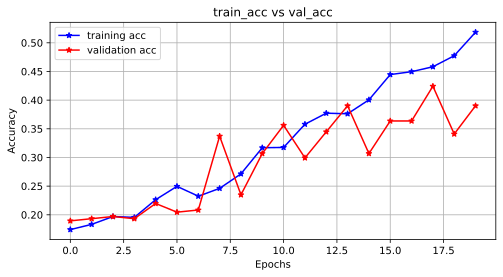

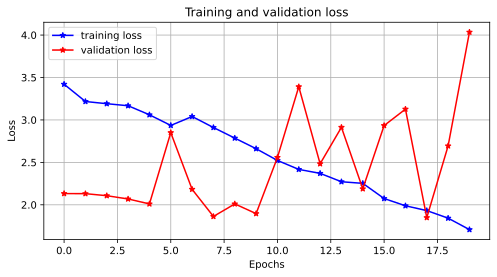

In [84]:
graph(history)

# Шаг2 Изменим количество неактивных слоев в сети imagenet и дообучим модель

In [85]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 80

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [86]:
# Посмотрим информацию о количестве слоев модели 

info_layers()

Number of layers in the model: 7
Number of trainable_variables layers in the model: 69
Number of layers in the base model:  132
Number of variables layers in the base model:  63
Layers in the model:
<tensorflow.python.keras.engine.functional.Functional object at 0x7f486b5a7910> True
<tensorflow.python.keras.layers.core.Flatten object at 0x7f486b46fc50> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f486b46f750> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f4821606a90> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f482164cb10> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f48215e8810> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f48215d2e50> True


In [87]:
# Посмотрим структуру модели

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               52429056  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1

In [88]:
# Компилируем модель

LR=0.00075
model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=optimizers.Adam(LR),loss=f1_loss, metrics=f1)
#model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=[tf.keras.metrics.Precision()])

In [ ]:
#scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
#print("Accuracy: %.2f%%" % (scores[1]*100))


In [89]:
%%time
history = model.fit(
        train_images, train_labels,
        steps_per_epoch=len(train_generator), #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 50, #EPOCHS,
        class_weight=class_weight,
        validation_data=test_generator,
        validation_steps=len(test_generator), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

Epoch 1/50
988/988 [==============================] - 48s 45ms/step - loss: 3.6619 - accuracy: 0.1908 - val_loss: 2.0668 - val_accuracy: 0.2652

Epoch 00001: val_accuracy did not improve from 0.42424
Epoch 2/50
988/988 [==============================] - 43s 44ms/step - loss: 2.8990 - accuracy: 0.2338 - val_loss: 3.4095 - val_accuracy: 0.3144

Epoch 00002: val_accuracy did not improve from 0.42424
Epoch 3/50
988/988 [==============================] - 43s 44ms/step - loss: 2.6372 - accuracy: 0.2914 - val_loss: 2.2840 - val_accuracy: 0.2841

Epoch 00003: val_accuracy did not improve from 0.42424
Epoch 4/50
988/988 [==============================] - 44s 44ms/step - loss: 2.8539 - accuracy: 0.2609 - val_loss: 3.2595 - val_accuracy: 0.3826

Epoch 00004: val_accuracy did not improve from 0.42424
Epoch 5/50
988/988 [==============================] - 43s 44ms/step - loss: 2.4525 - accuracy: 0.3670 - val_loss: 3.3840 - val_accuracy: 0.2424

Epoch 00005: val_accuracy did not improve from 0.42424


988/988 [==============================] - 44s 44ms/step - loss: 0.0766 - accuracy: 0.9768 - val_loss: 7.1841 - val_accuracy: 0.5492

Epoch 00040: val_accuracy did not improve from 0.58333
Epoch 41/50
988/988 [==============================] - 43s 44ms/step - loss: 0.1300 - accuracy: 0.9741 - val_loss: 7.2348 - val_accuracy: 0.5455

Epoch 00041: val_accuracy did not improve from 0.58333
Epoch 42/50
988/988 [==============================] - 43s 44ms/step - loss: 0.0576 - accuracy: 0.9850 - val_loss: 6.7998 - val_accuracy: 0.5758

Epoch 00042: val_accuracy did not improve from 0.58333
Epoch 43/50
988/988 [==============================] - 43s 44ms/step - loss: 0.0697 - accuracy: 0.9814 - val_loss: 7.7863 - val_accuracy: 0.5492

Epoch 00043: val_accuracy did not improve from 0.58333
Epoch 44/50
988/988 [==============================] - 43s 43ms/step - loss: 0.0944 - accuracy: 0.9787 - val_loss: 8.1824 - val_accuracy: 0.5227

Epoch 00044: val_accuracy did not improve from 0.58333
Epoch 4

In [90]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last_v2.hdf5')
model.load_weights('best_model.hdf5')

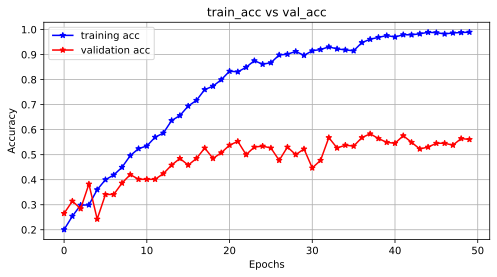

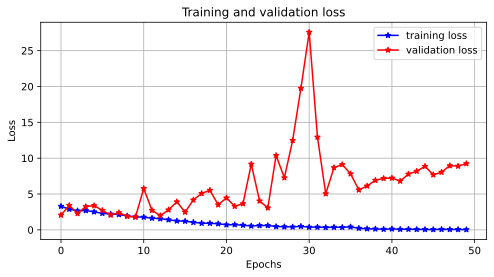

In [91]:
graph(history)

In [53]:
# Шаг3
#model = keras.models.load_model('/kaggle/input/inputqw/model_last_017_83.hdf5')

In [ ]:
# Шаг3 Снова изменим количество неактивных слоев в сети imagenet и дообучим модель

In [92]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 31

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


In [93]:
# Посмотрим информацию о количестве слоев модели 

info_layers()

Number of layers in the model: 7
Number of trainable_variables layers in the model: 126
Number of layers in the base model:  132
Number of variables layers in the base model:  120
Layers in the model:
<tensorflow.python.keras.engine.functional.Functional object at 0x7f486b5a7910> True
<tensorflow.python.keras.layers.core.Flatten object at 0x7f486b46fc50> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f486b46f750> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f4821606a90> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f482164cb10> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f48215e8810> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f48215d2e50> True


In [94]:
# Посмотрим структуру модели

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               52429056  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1

In [95]:
# Компилируем модель

LR=0.00095
model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
#print("Accuracy: %.2f%%" % (scores[1]*100))

In [96]:
%%time
history = model.fit(
        train_images, train_labels,
        steps_per_epoch=len(train_generator), #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 48, #EPOCHS,
        class_weight=class_weight,
        validation_data=test_generator,
        validation_steps=len(test_generator), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

Epoch 1/48
988/988 [==============================] - 61s 57ms/step - loss: 4.3516 - accuracy: 0.2494 - val_loss: 1.9481 - val_accuracy: 0.2879

Epoch 00001: val_accuracy did not improve from 0.58333
Epoch 2/48
988/988 [==============================] - 53s 54ms/step - loss: 2.7120 - accuracy: 0.3541 - val_loss: 2.9850 - val_accuracy: 0.3106

Epoch 00002: val_accuracy did not improve from 0.58333
Epoch 3/48
988/988 [==============================] - 52s 53ms/step - loss: 2.6104 - accuracy: 0.3586 - val_loss: 2.0545 - val_accuracy: 0.4091

Epoch 00003: val_accuracy did not improve from 0.58333
Epoch 4/48
988/988 [==============================] - 53s 54ms/step - loss: 2.2248 - accuracy: 0.4395 - val_loss: 1.6702 - val_accuracy: 0.4091

Epoch 00004: val_accuracy did not improve from 0.58333
Epoch 5/48
988/988 [==============================] - 52s 53ms/step - loss: 2.2786 - accuracy: 0.4240 - val_loss: 2.3565 - val_accuracy: 0.5000

Epoch 00005: val_accuracy did not improve from 0.58333


988/988 [==============================] - 52s 53ms/step - loss: 0.0311 - accuracy: 0.9929 - val_loss: 12.9663 - val_accuracy: 0.5492

Epoch 00041: val_accuracy did not improve from 0.60606
Epoch 42/48
988/988 [==============================] - 52s 53ms/step - loss: 0.0259 - accuracy: 0.9917 - val_loss: 7.6139 - val_accuracy: 0.5909

Epoch 00042: val_accuracy did not improve from 0.60606
Epoch 43/48
988/988 [==============================] - 53s 54ms/step - loss: 0.0115 - accuracy: 0.9974 - val_loss: 8.8563 - val_accuracy: 0.5417

Epoch 00043: val_accuracy did not improve from 0.60606
Epoch 44/48
988/988 [==============================] - 52s 52ms/step - loss: 0.0351 - accuracy: 0.9929 - val_loss: 11.2616 - val_accuracy: 0.5379

Epoch 00044: val_accuracy did not improve from 0.60606
Epoch 45/48
988/988 [==============================] - 52s 53ms/step - loss: 0.0168 - accuracy: 0.9974 - val_loss: 8.4955 - val_accuracy: 0.5114

Epoch 00045: val_accuracy did not improve from 0.60606
Epoch

In [97]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last_v3.hdf5')
model.load_weights('best_model.hdf5')

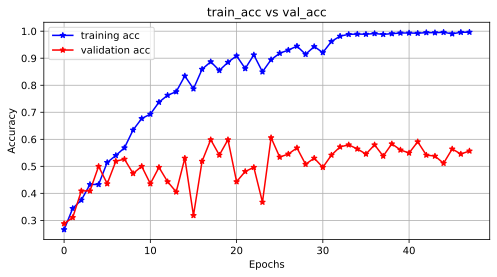

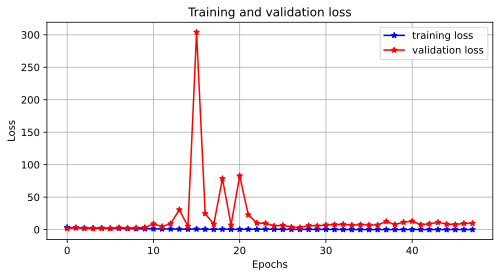

In [98]:
graph(history)

In [ ]:
# Шаг4

In [112]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 11

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False



In [113]:
# Посмотрим информацию о количестве слоев модели 

info_layers()

Number of layers in the model: 7
Number of trainable_variables layers in the model: 148
Number of layers in the base model:  132
Number of variables layers in the base model:  142
Layers in the model:
<tensorflow.python.keras.engine.functional.Functional object at 0x7f486b5a7910> True
<tensorflow.python.keras.layers.core.Flatten object at 0x7f486b46fc50> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f486b46f750> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f4821606a90> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f482164cb10> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f48215e8810> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f48215d2e50> True


In [114]:
# Посмотрим структуру модели

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               52429056  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1

In [115]:
# Компилируем модель

LR=0.00005
model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
%%time
history = model.fit(
        train_images, train_labels,
        steps_per_epoch=train_generator.samples, #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 45, #EPOCHS,
        class_weight=class_weight,
        validation_data=test_generator,
        validation_steps=(test_generator.samples), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

Epoch 1/25
1795/1795 [==============================] - 63s 33ms/step - loss: 3.3347 - precision_3: 0.1580 - val_loss: 1.9304 - val_precision_3: 0.8571
Epoch 2/25
1795/1795 [==============================] - 48s 26ms/step - loss: 3.3002 - precision_3: 0.0000e+00
Epoch 3/25
1795/1795 [==============================] - 48s 27ms/step - loss: 3.1320 - precision_3: 0.2635
Epoch 4/25
1795/1795 [==============================] - 48s 27ms/step - loss: 3.2217 - precision_3: 0.0000e+00
Epoch 5/25
1795/1795 [==============================] - 48s 27ms/step - loss: 3.2693 - precision_3: 0.0000e+00
Epoch 6/25
1023/1795 [================>.............] - ETA: 20s - loss: 3.2570 - precision_3: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last_19.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
graph2(history)

# Результаты

In [ ]:
# Считаем финальную точность модели по Accuracy и Loss

score_loss, score_acc = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("F1: %.2f%%" % (score_acc*100))
print("Loss: %.2f%%" % (score_loss))

## Confugn matrix по тестовым данным

In [99]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    # функция рисования confusion_matrix

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12,12))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

In [ ]:
%%time
Y_pred = model.predict(test_generator)  # test_val_generator
Y_pred

In [ ]:
y_pred2 = np.argmax(Y_pred, axis=1)
y_pred2

In [ ]:
cnf_matrix = confusion_matrix(test_generator.classes, y_pred2)

In [ ]:
classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

In [ ]:
list(classes.values())

In [ ]:
plot_confusion_matrix(cnf_matrix, list(classes.values()))

In [ ]:
# классификация ответов

print(classification_report(test_generator.classes, y_pred2, target_names=list(classes.values())))

In [ ]:
# Confugn matrix по валидационным данным

In [100]:
%%time
Y_pred1 = model.predict(test_val_generator,verbose=1)  # test_val_generator
y_pred_val = np.argmax(Y_pred1, axis=1)
y_pred_val

59/59 [==============================] - 12s 188ms/step
CPU times: user 10.9 s, sys: 1.26 s, total: 12.1 s
Wall time: 12.1 s


array([3, 3, 0, 5, 5, 0, 1, 5, 0, 5, 4, 1, 5, 5, 3, 7, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 5, 3, 4, 2, 7, 1, 2, 1,
       2, 1, 5, 5, 5, 3, 3, 4, 5, 3, 7, 5, 5, 4, 4, 8, 5, 3, 4, 3, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 5, 4, 4, 1, 1, 5, 4, 5, 5, 4, 3,
       4, 5, 5, 5, 1, 8, 5, 0, 3, 3, 3, 3, 8, 3, 3, 1, 1, 7, 1, 7, 5, 1,
       1, 0, 8, 7, 7, 8, 8, 8])

In [101]:
cnf_matrix_val = confusion_matrix(test_val_generator.classes, y_pred_val)
classes = {v: k for k, v in test_val_generator.class_indices.items()}
print(classes)

{0: 'actinic keratosis', 1: 'basal cell carcinoma', 2: 'dermatofibroma', 3: 'melanoma', 4: 'nevus', 5: 'pigmented benign keratosis', 6: 'seborrheic keratosis', 7: 'squamous cell carcinoma', 8: 'vascular lesion'}


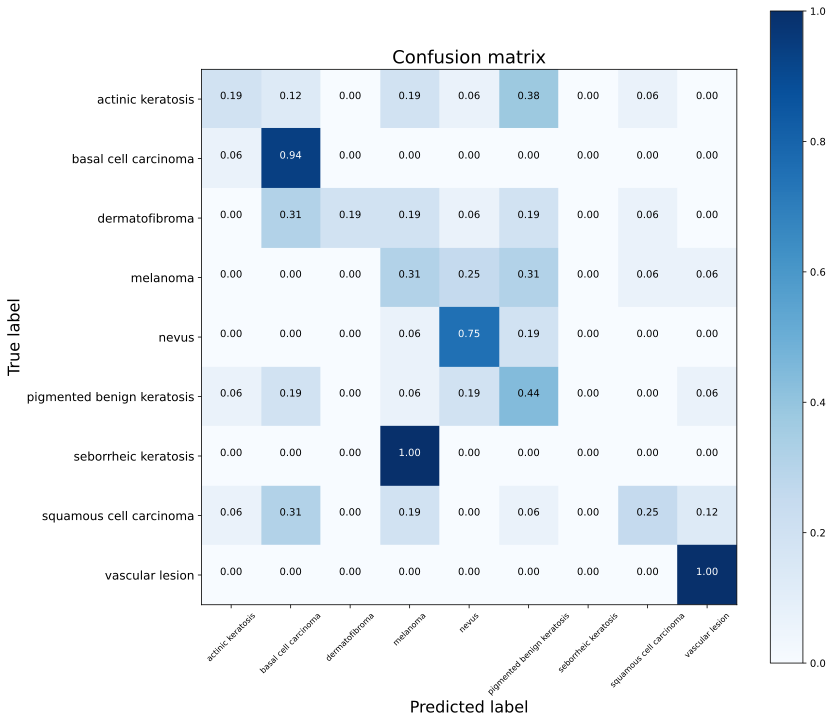

In [102]:
plot_confusion_matrix(cnf_matrix_val, list(classes.values()))

In [103]:
# классификация ответов

print(classification_report(test_val_generator.classes, y_pred_val, target_names=list(classes.values())))

                            precision    recall  f1-score   support

         actinic keratosis       0.50      0.19      0.27        16
      basal cell carcinoma       0.50      0.94      0.65        16
            dermatofibroma       1.00      0.19      0.32        16
                  melanoma       0.26      0.31      0.29        16
                     nevus       0.57      0.75      0.65        16
pigmented benign keratosis       0.28      0.44      0.34        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.57      0.25      0.35        16
           vascular lesion       0.43      1.00      0.60         3

                  accuracy                           0.44       118
                 macro avg       0.46      0.45      0.38       118
              weighted avg       0.51      0.44      0.40       118



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Tестовая демонстрация.

In [ ]:
def load_image(filename):
    # загружает картинку
    
    img = cv2.imread(os.path.join(train_path, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    return img

def predict(image):
    # возвращает первые три максимальных значений из предсказанных для каждого класса
    tta_step = 3
    predictions = []
    for i in range(tta_step):
        preds = model.predict(np.asarray([img]))[0]
        predictions.append(preds)
    pred = np.mean(predictions, axis=0)
    probabilities = pred
#    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = (-probabilities).argsort()[:3]  # np.argmax(probabilities)
    return class_idx, probabilities[class_idx]

In [ ]:
classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

In [ ]:
for idx, filename in enumerate(random.sample(test_generator.filenames, 3)):    # test_val_generator
    print("Источник: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("Предсказано: класс: %s, с вероятностью: %f" % (classes[prediction[0][0]], prediction[1][0]))
    print("Предсказано: класс: %s, с вероятностью: %f" % (classes[prediction[0][1]], prediction[1][1]))
    print("Предсказано: класс: %s, с вероятностью: %f" % (classes[prediction[0][2]], prediction[1][2]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

# Выводы:
#     На несбалансированной выборке с небольшим набором данных удалось добиться точности за счет следующих шагов:
#         1. выбор подходящей к задаче архитектуры сети c Fine-tuning
#         2. задание весов для классов
#         3. уменьшение batch_size
#         4. подбор LR
#         5. использование аугментации ablumentation
        